In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cu

# Forward Net by Class

### Every Class needs forward(), backward(), params, grads

In [5]:
class Sigmoid:
    def __init__(self):
        self.params = []

    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [6]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        return out

### Simple Two Layer Net

In [7]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]

        # 모든 가중치를 리스트에 모은다.
        self.params = []
        for layer in self.layers:
            self.params += layer.params

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

### Using TwoLayerNet to predict

In [10]:
x = np.random.randn(10, 2)
model = TwoLayerNet(2, 4, 3)
s = model.predict(x)
print(s)

[[-1.42588136  0.10154126 -0.44109171]
 [-1.35685624  0.1880891  -0.64877906]
 [-1.15355168  0.25139452 -0.55748445]
 [-1.06367281  0.3989011  -0.91857105]
 [-1.3805156   0.16495086 -0.60169097]
 [-1.08202613  0.38526998 -0.9039076 ]
 [-0.88645643  0.49356299 -0.9327719 ]
 [-1.06444282  0.34714702 -0.75637324]
 [-1.27322471  0.27727606 -0.83564441]
 [-1.31550225  0.14034297 -0.40954816]]


# Learning Of Net

### Calculating The Loss

In [12]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [13]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size # 정답레이블이 1이였던 곳의 y를 넣어줌!

# Complete Layers

### MatMul

In [16]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

### Sigmoid

In [17]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

### Affine

In [18]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

### SoftMaxWithLoss

In [20]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t): 
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환 => same as crossEntropyError!
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1 # 필요한 곳만 계산!
        dx *= dout
        dx = dx / batch_size # 마자막에 더하고 정규화 내기 때문!

        return dx

# Train Weights

### SGD implementation

In [22]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

### Spiral dataset

In [23]:
import sys
sys.path.append("../book/") #이렇게 임포트 경로 바꿔야 함!!

In [24]:
from dataset import spiral
x, t = spiral.load_data()

print('x', x.shape)
print('t', t.shape)

x (300, 2)
t (300, 3)


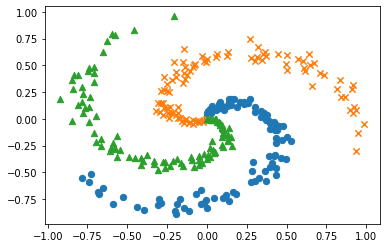

In [25]:
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

### Simple Network
* network has to have predict, forward, backward!

In [27]:
from common.layers import Affine, Sigmoid, SoftmaxWithLoss


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], [] #메모리가 공유되어 이것 사용해서 접근 가능!
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1): #calculate and store gradients in net
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout


### Trainer
* move weights by gradients

In [29]:
# 하이퍼파라미터 설정
max_epoch = 600
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 모델과 옵티마이저 생성
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads) #이렇게 옵티마이져 사용!!

        total_loss += loss
        loss_count += 1

        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d |  반복 %d / %d | 손실 %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0


| 에폭 1 |  반복 10 / 10 | 손실 1.14
| 에폭 2 |  반복 10 / 10 | 손실 1.15
| 에폭 3 |  반복 10 / 10 | 손실 1.16
| 에폭 4 |  반복 10 / 10 | 손실 1.11
| 에폭 5 |  반복 10 / 10 | 손실 1.16
| 에폭 6 |  반복 10 / 10 | 손실 1.14
| 에폭 7 |  반복 10 / 10 | 손실 1.16
| 에폭 8 |  반복 10 / 10 | 손실 1.13
| 에폭 9 |  반복 10 / 10 | 손실 1.12
| 에폭 10 |  반복 10 / 10 | 손실 1.13
| 에폭 11 |  반복 10 / 10 | 손실 1.13
| 에폭 12 |  반복 10 / 10 | 손실 1.08
| 에폭 13 |  반복 10 / 10 | 손실 1.05
| 에폭 14 |  반복 10 / 10 | 손실 1.02
| 에폭 15 |  반복 10 / 10 | 손실 1.00
| 에폭 16 |  반복 10 / 10 | 손실 0.93
| 에폭 17 |  반복 10 / 10 | 손실 0.91
| 에폭 18 |  반복 10 / 10 | 손실 0.88
| 에폭 19 |  반복 10 / 10 | 손실 0.85
| 에폭 20 |  반복 10 / 10 | 손실 0.84
| 에폭 21 |  반복 10 / 10 | 손실 0.83
| 에폭 22 |  반복 10 / 10 | 손실 0.79
| 에폭 23 |  반복 10 / 10 | 손실 0.81
| 에폭 24 |  반복 10 / 10 | 손실 0.77
| 에폭 25 |  반복 10 / 10 | 손실 0.80
| 에폭 26 |  반복 10 / 10 | 손실 0.78
| 에폭 27 |  반복 10 / 10 | 손실 0.76
| 에폭 28 |  반복 10 / 10 | 손실 0.80
| 에폭 29 |  반복 10 / 10 | 손실 0.76
| 에폭 30 |  반복 10 / 10 | 손실 0.75
| 에폭 31 |  반복 10 / 10 | 손실 0.78
| 에폭 32 |  반복 10 

| 에폭 502 |  반복 10 / 10 | 손실 0.08
| 에폭 503 |  반복 10 / 10 | 손실 0.08
| 에폭 504 |  반복 10 / 10 | 손실 0.08
| 에폭 505 |  반복 10 / 10 | 손실 0.08
| 에폭 506 |  반복 10 / 10 | 손실 0.08
| 에폭 507 |  반복 10 / 10 | 손실 0.08
| 에폭 508 |  반복 10 / 10 | 손실 0.09
| 에폭 509 |  반복 10 / 10 | 손실 0.08
| 에폭 510 |  반복 10 / 10 | 손실 0.08
| 에폭 511 |  반복 10 / 10 | 손실 0.07
| 에폭 512 |  반복 10 / 10 | 손실 0.08
| 에폭 513 |  반복 10 / 10 | 손실 0.08
| 에폭 514 |  반복 10 / 10 | 손실 0.08
| 에폭 515 |  반복 10 / 10 | 손실 0.08
| 에폭 516 |  반복 10 / 10 | 손실 0.08
| 에폭 517 |  반복 10 / 10 | 손실 0.07
| 에폭 518 |  반복 10 / 10 | 손실 0.09
| 에폭 519 |  반복 10 / 10 | 손실 0.08
| 에폭 520 |  반복 10 / 10 | 손실 0.08
| 에폭 521 |  반복 10 / 10 | 손실 0.08
| 에폭 522 |  반복 10 / 10 | 손실 0.08
| 에폭 523 |  반복 10 / 10 | 손실 0.07
| 에폭 524 |  반복 10 / 10 | 손실 0.08
| 에폭 525 |  반복 10 / 10 | 손실 0.08
| 에폭 526 |  반복 10 / 10 | 손실 0.08
| 에폭 527 |  반복 10 / 10 | 손실 0.08
| 에폭 528 |  반복 10 / 10 | 손실 0.08
| 에폭 529 |  반복 10 / 10 | 손실 0.08
| 에폭 530 |  반복 10 / 10 | 손실 0.08
| 에폭 531 |  반복 10 / 10 | 손실 0.07
| 에폭 532 |

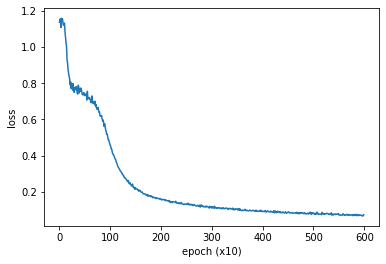

In [32]:
# 학습 결과 플롯
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('epoch (x10)')
plt.ylabel('loss')
plt.show()

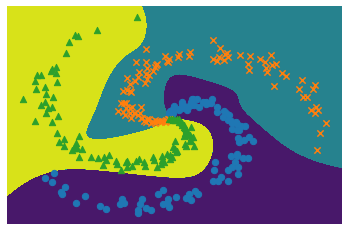

In [33]:
# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

### Using Trainer to simplify training!
* to initialize, input a model and an optimizer

In [36]:
from common.trainer import Trainer

model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)

| 에폭 1 |  반복 1 / 10 | 시간 0[s] | 손실 1.10
| 에폭 2 |  반복 1 / 10 | 시간 0[s] | 손실 1.14
| 에폭 3 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 4 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 5 |  반복 1 / 10 | 시간 0[s] | 손실 1.14
| 에폭 6 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 7 |  반복 1 / 10 | 시간 0[s] | 손실 1.14
| 에폭 8 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 9 |  반복 1 / 10 | 시간 0[s] | 손실 1.13
| 에폭 10 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 11 |  반복 1 / 10 | 시간 0[s] | 손실 1.12
| 에폭 12 |  반복 1 / 10 | 시간 0[s] | 손실 1.09
| 에폭 13 |  반복 1 / 10 | 시간 0[s] | 손실 1.07
| 에폭 14 |  반복 1 / 10 | 시간 0[s] | 손실 1.03
| 에폭 15 |  반복 1 / 10 | 시간 0[s] | 손실 0.99
| 에폭 16 |  반복 1 / 10 | 시간 0[s] | 손실 0.96
| 에폭 17 |  반복 1 / 10 | 시간 0[s] | 손실 0.94
| 에폭 18 |  반복 1 / 10 | 시간 0[s] | 손실 0.93
| 에폭 19 |  반복 1 / 10 | 시간 0[s] | 손실 0.90
| 에폭 20 |  반복 1 / 10 | 시간 0[s] | 손실 0.87
| 에폭 21 |  반복 1 / 10 | 시간 0[s] | 손실 0.83
| 에폭 22 |  반복 1 / 10 | 시간 0[s] | 손실 0.83
| 에폭 23 |  반복 1 / 10 | 시간 0[s] | 손실 0.82
| 에폭 24 |  반복 1 / 10 | 시간 0[s] | 손실 0.82
| 에폭 25 |  반복 1 / 10 | 시간

| 에폭 240 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 241 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 242 |  반복 1 / 10 | 시간 0[s] | 손실 0.16
| 에폭 243 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 244 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 245 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 246 |  반복 1 / 10 | 시간 0[s] | 손실 0.16
| 에폭 247 |  반복 1 / 10 | 시간 0[s] | 손실 0.17
| 에폭 248 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 249 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 250 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 251 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 252 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 253 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 254 |  반복 1 / 10 | 시간 0[s] | 손실 0.16
| 에폭 255 |  반복 1 / 10 | 시간 0[s] | 손실 0.13
| 에폭 256 |  반복 1 / 10 | 시간 0[s] | 손실 0.16
| 에폭 257 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 258 |  반복 1 / 10 | 시간 0[s] | 손실 0.15
| 에폭 259 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 260 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 261 |  반복 1 / 10 | 시간 0[s] | 손실 0.14
| 에폭 262 |  반복 1 / 10 | 시간 0[s] | 손실 0.16
| 에폭 263 |  반복 1 / 10 | 시간 0[s] | 

| 에폭 485 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 486 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 487 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 488 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 489 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 490 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 491 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 492 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 493 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 494 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 495 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 496 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 497 |  반복 1 / 10 | 시간 0[s] | 손실 0.10
| 에폭 498 |  반복 1 / 10 | 시간 0[s] | 손실 0.07
| 에폭 499 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 500 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 501 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 502 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 503 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 504 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 505 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 506 |  반복 1 / 10 | 시간 0[s] | 손실 0.09
| 에폭 507 |  반복 1 / 10 | 시간 0[s] | 손실 0.08
| 에폭 508 |  반복 1 / 10 | 시간 0[s] | 

/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/dongho/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


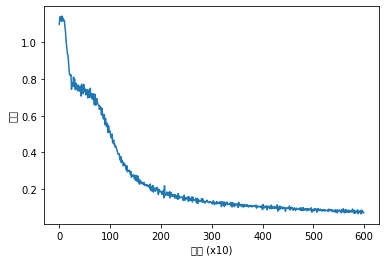

In [37]:
trainer.plot() # plot the loss graph!

# Faster Training
* change data types
* Use GPU

In [38]:
# use 64bit?
import numpy as np
a = np.random.randn(3)
print(a.dtype)

float64


In [39]:
c = np.random.randn(3).astype("f")
print(c.dtype)

float32


In [42]:
# Use GPU
import cupy as cp
x = cp.arange(6).reshape(2,3).astype('f')

In [43]:
print(x)
print(x.sum(axis=1))
print(type(x))

[[0. 1. 2.]
 [3. 4. 5.]]
[ 3. 12.]
<class 'cupy._core.core.ndarray'>
